In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

## Load Data

In [2]:
# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted successfully")
except Exception as e:
    print(f"Error mounting drive: {e}")

# Data Loading Functions
def load_csv(file_path, name=""):
    """Load CSV file with error handling."""
    try:
        df = pd.read_csv(file_path)
        print(f"{name} shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {name}: {e}")
        return None

Mounted at /content/drive
Drive mounted successfully


In [3]:
# Define file paths
base_path = "/content/drive/My Drive/data_test/"
data_files = {
    'train_cat': 'TRAIN_CATEGORICAL.csv',
    'train_fcm': 'TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv',
    'train_quant': 'TRAIN_QUANTITATIVE.csv',
    'train_solutions': 'TRAINING_SOLUTIONS.csv',
    'test_cat': 'TEST_CATEGORICAL.csv',
    'test_quant': 'TEST_QUANTITATIVE.csv',
    'test_fcm': 'TEST_FCM.csv'
}

# Load all datasets
datasets = {}
for name, filename in data_files.items():
    datasets[name] = load_csv(base_path + filename, name)

# Check if all datasets loaded successfully
if any(df is None for df in datasets.values()):
    raise Exception("One or more datasets failed to load")

train_cat shape: (1213, 10)
train_fcm shape: (1213, 19901)
train_quant shape: (1213, 19)
train_solutions shape: (1213, 5)
test_cat shape: (304, 10)
test_quant shape: (304, 19)
test_fcm shape: (304, 19901)


## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a way to understand your dataset by looking at its patterns, trends, and relationships. It helps identify missing data, outliers, and how variables interact.

Use `.info()` and `.describe()` to summarize each dataset.

In [ ]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 5   MRI_Track_Scan_Location           1213 non-null   int64  
 6   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 7   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 8   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 9   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 94.9+ KB


Understand the distribution of the categorical variables with `.value_counts()`.

In [ ]:
#Barratt_Barratt_P2_Occ - Barratt Simplified Measure of Social Status - Parent 2 Occupation
train_cat['Barratt_Barratt_P2_Occ'].value_counts()

#Look back at the dictionary on Kaggle!
# to see what category these integers [0, 45, 35...] represent.

,count
Barratt_Barratt_P2_Occ,
0,287
45,239
35,195
30,149
40,116
15,86
20,41
5,38
10,37


Visualize distributions:

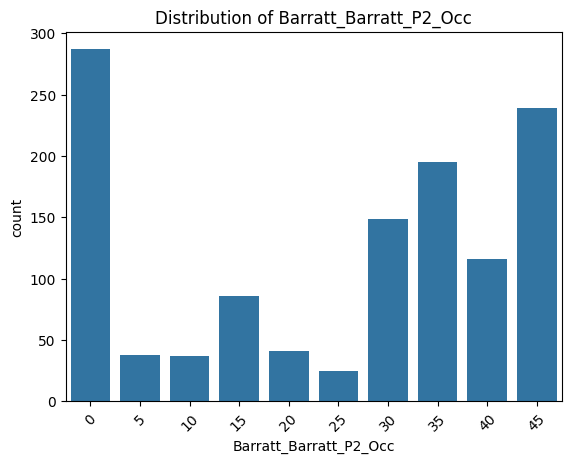

In [ ]:
sns.countplot(x='Barratt_Barratt_P2_Occ', data=train_cat[['Barratt_Barratt_P2_Occ']])
plt.title(f"Distribution of Barratt_Barratt_P2_Occ")
plt.xticks(rotation=45)
plt.show()

Understand the distribution of quantitative variables.

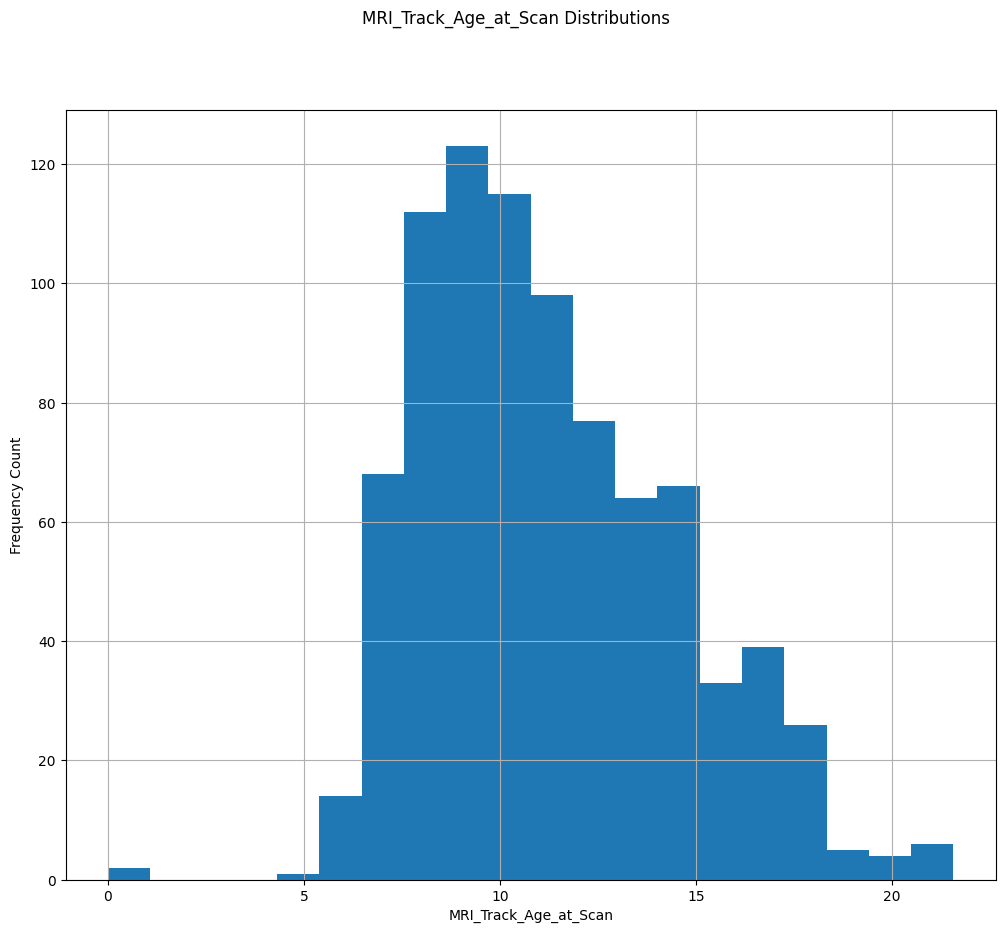

In [ ]:
# Distribution of MRI_Track_Age_at_Scan
train_Quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()


The train_Solutions dataset contains labels for `ADHD` and `gender`. Let's examine the class distribution.

In [ ]:
# ADHD distribution
train_Solutions['ADHD_Outcome'].value_counts()

,count
ADHD_Outcome,
1,831
0,382


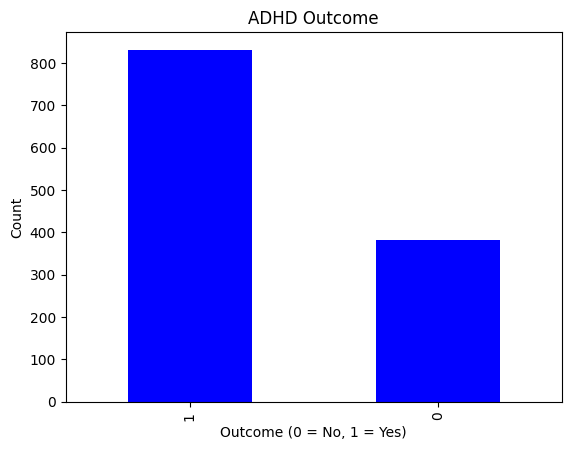

In [ ]:
train_Solutions['ADHD_Outcome'].value_counts().plot(kind='bar', color='blue')
plt.title('ADHD Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Gender distribution
train_Solutions['Sex_F'].value_counts()

,count
Sex_F,
0,797
1,416


**Key Insight**: Gender imbalance in the dataset may introduce bias in modeling. Address this during data preparation.

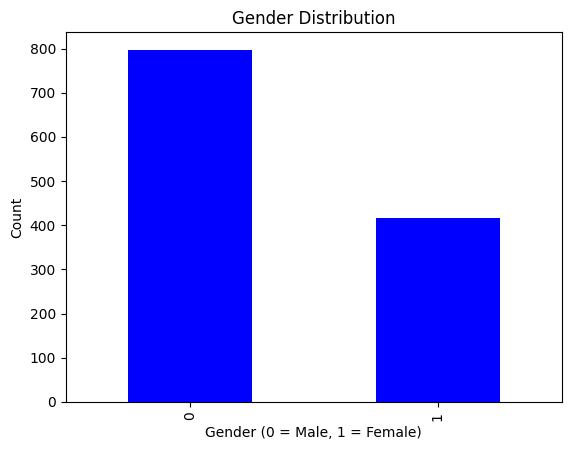

In [ ]:
train_Solutions['Sex_F'].value_counts().plot(kind='bar', color='blue')
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

### How to Test Predictiveness:

In [ ]:
train_Quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

Let's look at the `SDQ_SDQ_Emotional_Problems`, which indicates Emotional Problems Scale.

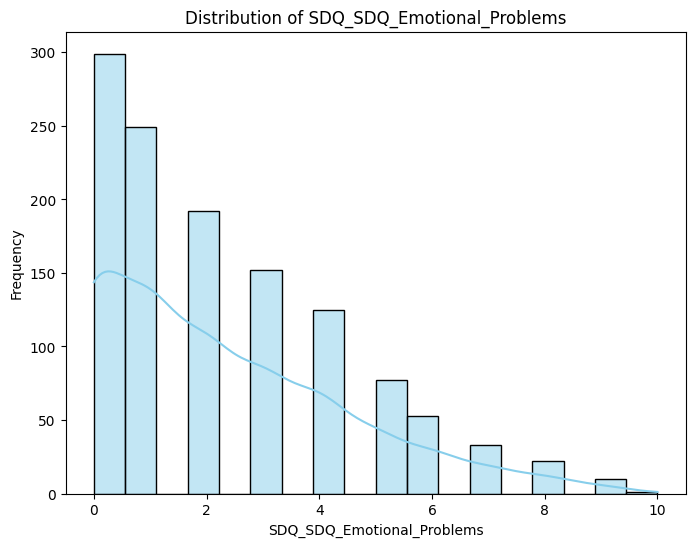

In [ ]:
# Plot the distribution of the SDQ_SDQ_Emotional_Problems variable
plt.figure(figsize=(8, 6))
sns.histplot(train_Quant['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()

This boxplot examines the relationship between `SDQ_SDQ_Emotional_Problems` and `ADHD_outcome` (as a target variable).

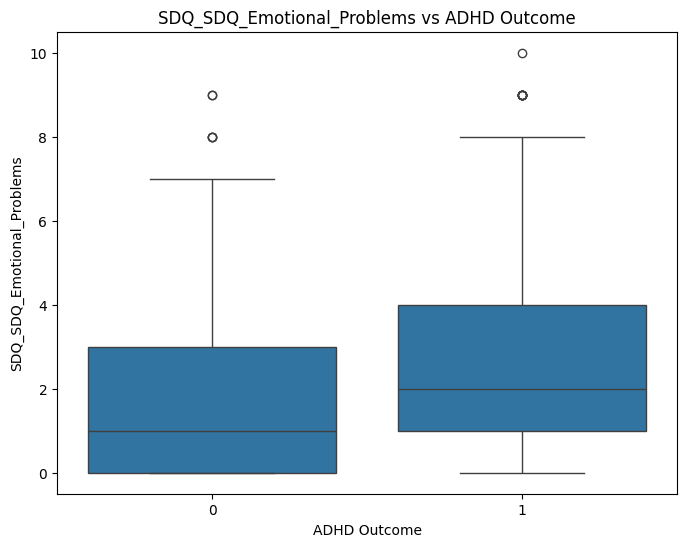

In [ ]:
# Check for correlation with ADHD outcome
train_Quant_copy = train_Quant.copy()
train_Quant_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Emotional_Problems', data=train_Quant_copy)
plt.title('SDQ_SDQ_Emotional_Problems vs ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('SDQ_SDQ_Emotional_Problems')
plt.show()


The boxplot reveals that individuals diagnosed with ADHD tend to have a higher median on the SDQ Emotional Problems scale compared to non-ADHD individuals. Additionally, the boxplot for the ADHD group displays greater variability, as evidenced by its extended range. This suggests that emotional problems are not only more pronounced but also more diverse within the ADHD group.

##### **Categorical Data**: Use bar plots to compare groups (e.g., ADHD rates by Parent 1 occupation).


In [ ]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

Let's look at `Barratt_Barratt_P1_Edu` which indicates the Parent 1 level of education

- 3=Less than 7th grade
- 6=Junior high/Middle school (9th grade)
- 9=Partial high school (10th or 11th grade)
- 12=High school graduate
- 15=Partial college (at least one year)
- 18=College education
- 21=Graduate degree

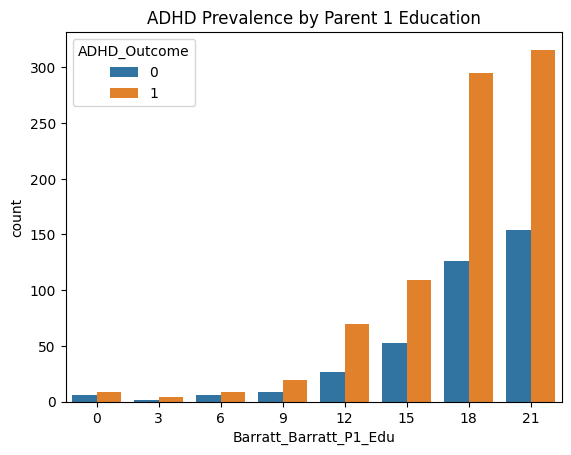

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_cat, x='Barratt_Barratt_P1_Edu', hue=train_Solutions['ADHD_Outcome'])
plt.title('ADHD Prevalence by Parent 1 Education')
plt.show()

In [ ]:
train_cat['Barratt_Barratt_P1_Edu'].value_counts()

,count
Barratt_Barratt_P1_Edu,
21,470
18,421
15,162
12,97
9,28
0,15
6,15
3,5


Most of the data points fall into a specific category (e.g., 21 has 470 entries out of a total 1213). This means that even if ADHD prevalence appears higher in this category, it might just reflect that there are more people in this group overall, rather than an actual trend.

To adress this, normalize the data or compute percentages within each category to account for differences in group sizes. Let's compute ADHD percentage for each category.

In [ ]:
# Add ADHD_Outcome directly to a copy of the train_cat dataset for grouping
train_cat_copy = train_cat.copy()
train_cat_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

adhd_percentages = train_cat_copy.groupby('Barratt_Barratt_P1_Edu')['ADHD_Outcome'].mean()
print(adhd_percentages)

Barratt_Barratt_P1_Edu
0     0.600000
3     0.800000
6     0.600000
9     0.678571
12    0.721649
15    0.672840
18    0.700713
21    0.672340
Name: ADHD_Outcome, dtype: float64


Categories like 3 - Less than 7th grade (80%) and 12 - High school graduate (72%) show some of the highest proportions of ADHD outcomes. Categories 21 - Graduate degree (67.2%) have relatively lower ADHD proportions compared to middle education levels.

In [ ]:
train_cat['Barratt_Barratt_P1_Edu'].value_counts()

,count
Barratt_Barratt_P1_Edu,
21,470
18,421
15,162
12,97
9,28
0,15
6,15
3,5


# Load & Merge Test Data

In [6]:
# Data Merging
def merge_datasets(cat_df, quant_df, name=""):
    """Merge categorical and quantitative datasets."""
    merged_df = pd.merge(cat_df, quant_df, on='participant_id', how='inner')

    print(f"{name} merged shape: {merged_df.shape}")
    return merged_df
############################################################################
# # Data Merging
# def merge_datasets(cat_df, quant_df, fcm_df, name=""):
#     """Merge categorical, quantitative, and functional connectome datasets."""
#     # First merge cat_df and quant_df
#     merged_df = pd.merge(cat_df, quant_df, on='participant_id', how='inner')
#     # Then merge the result with fcm_df
#     merged_df = pd.merge(merged_df, fcm_df, on='participant_id', how='inner')

#     print(f"{name} merged shape: {merged_df.shape}")
#     return merged_df

In [7]:
# Prepare training and test data
train_df = merge_datasets(datasets['train_cat'], datasets['train_quant'], "Training")
test_df = merge_datasets(datasets['test_cat'], datasets['test_quant'], "Test")

# train_df = merge_datasets(datasets['train_cat'], datasets['train_quant'], datasets['train_fcm'], "Training")
# test_df = merge_datasets(datasets['test_cat'], datasets['test_quant'], datasets['test_fcm'], "Test")

# Prepare features and targets
X_train = train_df.drop(columns=['participant_id'])
Y_train = datasets['train_solutions'][['ADHD_Outcome', 'Sex_F']]
participant_ids = test_df['participant_id']
X_test = test_df.drop(columns=['participant_id'])

Training merged shape: (1213, 28)
Test merged shape: (304, 28)


# Machine Learning

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, make_scorer

In [9]:
# Machine Learning Pipeline
def create_preprocessor(X):
    """Create preprocessing pipeline for numeric and categorical features."""
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    return ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [10]:
# Define custom scoring function
def multi_output_accuracy(y_true, y_pred):
    """Calculate average accuracy across multiple outputs."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i])
                   for i in range(y_true.shape[1])])

In [11]:
# Split training data into train and validation sets
X_train_split, X_val, Y_train_split, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

In [12]:
# Create and train model
preprocessor = create_preprocessor(X_train)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    )))
])

In [13]:
# Hyperparameter tuning
param_dist = {
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],
    'classifier__estimator__max_depth': [3, 5, 7],
    'classifier__estimator__subsample': [0.8, 0.9, 1.0],
    'classifier__estimator__colsample_bytree': [0.8, 0.9, 1.0]
}

In [14]:
# Perform randomized search
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=make_scorer(multi_output_accuracy),
    random_state=42,
    n_jobs=-1,
    verbose=1
)


# Fit model and get results
search.fit(X_train, Y_train)
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__estimator__subsample': 1.0, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__max_depth': 3, 'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__colsample_bytree': 0.9}
Best cross-validation score: 0.7349505152535455


## Model Evaluation and Visualization

In [15]:
# Predict on validation set
Y_val_pred = search.predict(X_val)
Y_val_pred_proba = search.predict_proba(X_val)  # Probability predictions for ROC-AUC

# Extract predictions and true values for each target
Y_val_adhd, Y_val_sex = Y_val['ADHD_Outcome'], Y_val['Sex_F']
Y_pred_adhd, Y_pred_sex = Y_val_pred[:, 0], Y_val_pred[:, 1]
Y_pred_proba_adhd = [x[1] for x in Y_val_pred_proba[0]]  # Probability of positive class for ADHD
Y_pred_proba_sex = [x[1] for x in Y_val_pred_proba[1]]   # Probability of positive class for Sex_F

def print_metrics(y_true, y_pred, y_pred_proba, target_name):
    print(f"\n--- Metrics for {target_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Print metrics for each target
print_metrics(Y_val_adhd, Y_pred_adhd, Y_pred_proba_adhd, "ADHD_Outcome")
print_metrics(Y_val_sex, Y_pred_sex, Y_pred_proba_sex, "Sex_F")


--- Metrics for ADHD_Outcome ---
Accuracy: 0.852
Precision: 0.850
Recall: 0.952
F1-Score: 0.898
ROC-AUC: 0.940

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        76
           1       0.85      0.95      0.90       167

    accuracy                           0.85       243
   macro avg       0.85      0.79      0.81       243
weighted avg       0.85      0.85      0.84       243


--- Metrics for Sex_F ---
Accuracy: 0.823
Precision: 0.935
Recall: 0.518
F1-Score: 0.667
ROC-AUC: 0.906

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       160
           1       0.93      0.52      0.67        83

    accuracy                           0.82       243
   macro avg       0.87      0.75      0.77       243
weighted avg       0.84      0.82      0.81       243



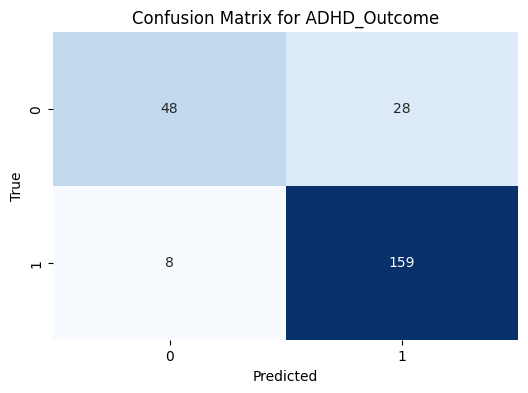

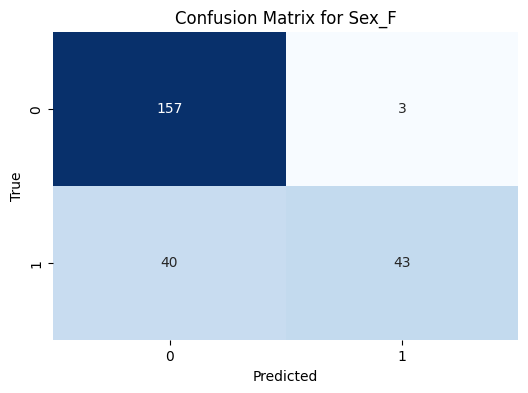

In [16]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, target_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {target_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(Y_val_adhd, Y_pred_adhd, "ADHD_Outcome")
plot_confusion_matrix(Y_val_sex, Y_pred_sex, "Sex_F")

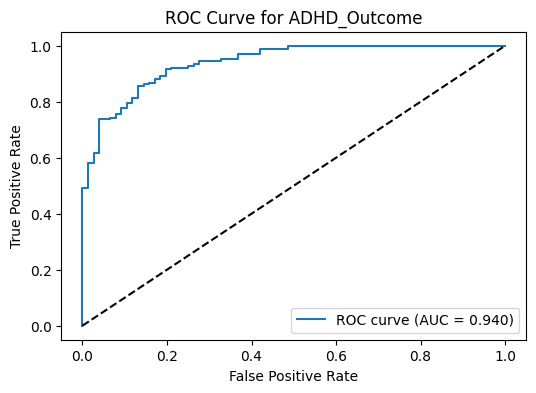

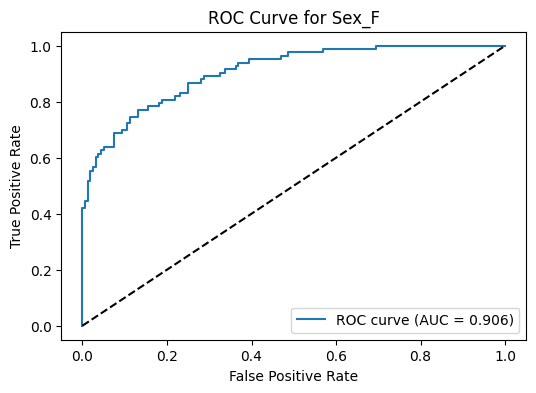

In [17]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, target_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {target_name}')
    plt.legend(loc='best')
    plt.show()

# Plot ROC curves
plot_roc_curve(Y_val_adhd, Y_pred_proba_adhd, "ADHD_Outcome")
plot_roc_curve(Y_val_sex, Y_pred_proba_sex, "Sex_F")

## Prediction submission.csv

In [18]:
# Make predictions
y_pred = search.predict(X_test)
predictions_df = pd.DataFrame(
    y_pred,
    columns=['Predicted_ADHD', 'Predicted_Sex'],
    index=participant_ids
).reset_index()

# Save results
output_path = 'submission.csv'
predictions_df.to_csv(output_path, index=False)
print(f"Predictions saved to {output_path}")
print(predictions_df.head())

Predictions saved to submission.csv
  participant_id  Predicted_ADHD  Predicted_Sex
0   Cfwaf5FX7jWK               1              0
1   vhGrzmvA3Hjq               1              1
2   ULliyEXjy4OV               1              0
3   LZfeAb1xMtql               1              0
4   EnFOUv0YK1RG               1              0
